In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pypsa
import pandas as pd
import os

plt.style.use(["bmh", "../../matplotlibrc"])
sns.set_palette("colorblind")

COUNTRY = "UK"

In [42]:
files = {
    "VOLL": f"../../results/20240506-70a/network_solved_LT-country+{COUNTRY}-voll+true.nc",
    "PWL-elastic": f"../../results/20240506-70a/network_solved_LT-country+{COUNTRY}-elastic_pwl+default.nc",
}
ns = {k: pypsa.Network(v) for k, v in files.items()}

INFO:pypsa.io:Imported network network_solved_LT-country+UK-voll+true.nc has buses, carriers, generators, links, loads, stores
INFO:pypsa.io:Imported network network_solved_LT-country+UK-elastic_pwl+default.nc has buses, carriers, generators, links, loads, stores


In [43]:
def get_annual_revenues(n):
    revenue = n.statistics.revenue(aggregate_time=False).groupby("carrier").sum().T.drop("load", axis=1)
    annual_revenue = revenue.groupby(revenue.index.year).sum()
    to_combine = ["battery charger", "battery discharger"]
    annual_revenue["battery dis-/charging"] = annual_revenue[to_combine].sum(axis=1)
    annual_revenue = annual_revenue.drop(to_combine, axis=1)
    normed_annual_revenue = annual_revenue / annual_revenue.mean() * 1 - 1
    return normed_annual_revenue # p.u.

In [44]:
revenues = pd.concat({k: get_annual_revenues(v) for k, v in ns.items()})
revenues.index.names = ["scenario", "year"]
revenues

carrier           battery storage  hydrogen electrolyser  hydrogen fuel cell  \
scenario    year                                                               
VOLL        1951        -0.997267              -0.999931           -0.999929   
            1952        -0.700043              -0.999977            0.101495   
            1953        -0.848526              -0.999964           -0.417838   
            1954        -0.997414              -0.999977           -1.000000   
            1955        -0.848170              -0.999886            0.060760   
...                           ...                    ...                 ...   
PWL-elastic 2016         0.018064              -0.167596           -0.096041   
            2017        -0.334069              -0.272439           -0.610749   
            2018        -0.282336              -0.305089           -0.652832   
            2019        -0.231974              -0.400043           -0.008341   
            2020        -0.247776              -0.187895           -0.114777   

carrier           hydrogen storage     solar      wind  battery dis-/charging  
scenario    year                                                               
VOLL        1951         -1.003443 -0.994322 -0.994328              -0.998590  
            1952         -1.000702 -0.907061 -0.909482              -0.997757  
            1953         -0.991686 -0.964627 -0.931431              -0.997718  
            1954         -1.011292 -0.994499 -0.993994              -0.998263  
            1955         -1.000175 -0.873652 -0.882359              -0.996384  
...                            ...       ...       ...                    ...  
PWL-elastic 2016          1.480574 -0.048995 -0.082452              -0.251291  
            2017         -2.123361 -0.448099 -0.325176              -0.450058  
            2018         -0.686720 -0.377840 -0.395166              -0.319973  
            2019         -0.701033 -0.349227 -0.263724              -0.427998  
            2020         -2.218741 -0.366272 -0.358141              -0.383838  

[140 rows x 7 columns]

In [45]:
revenues_long = pd.melt(
    revenues.reset_index(),
    id_vars=['scenario', 'year'],
    var_name='carrier',
    value_name='value'
)

In [46]:
revenues_long["carrier"] = revenues_long["carrier"].str.replace("fuel cell", "turbine")
revenues_long["carrier"] = revenues_long["carrier"].str.replace(" ", "\n")
revenues_long.sort_values(by="carrier", ascending=False, inplace=True)

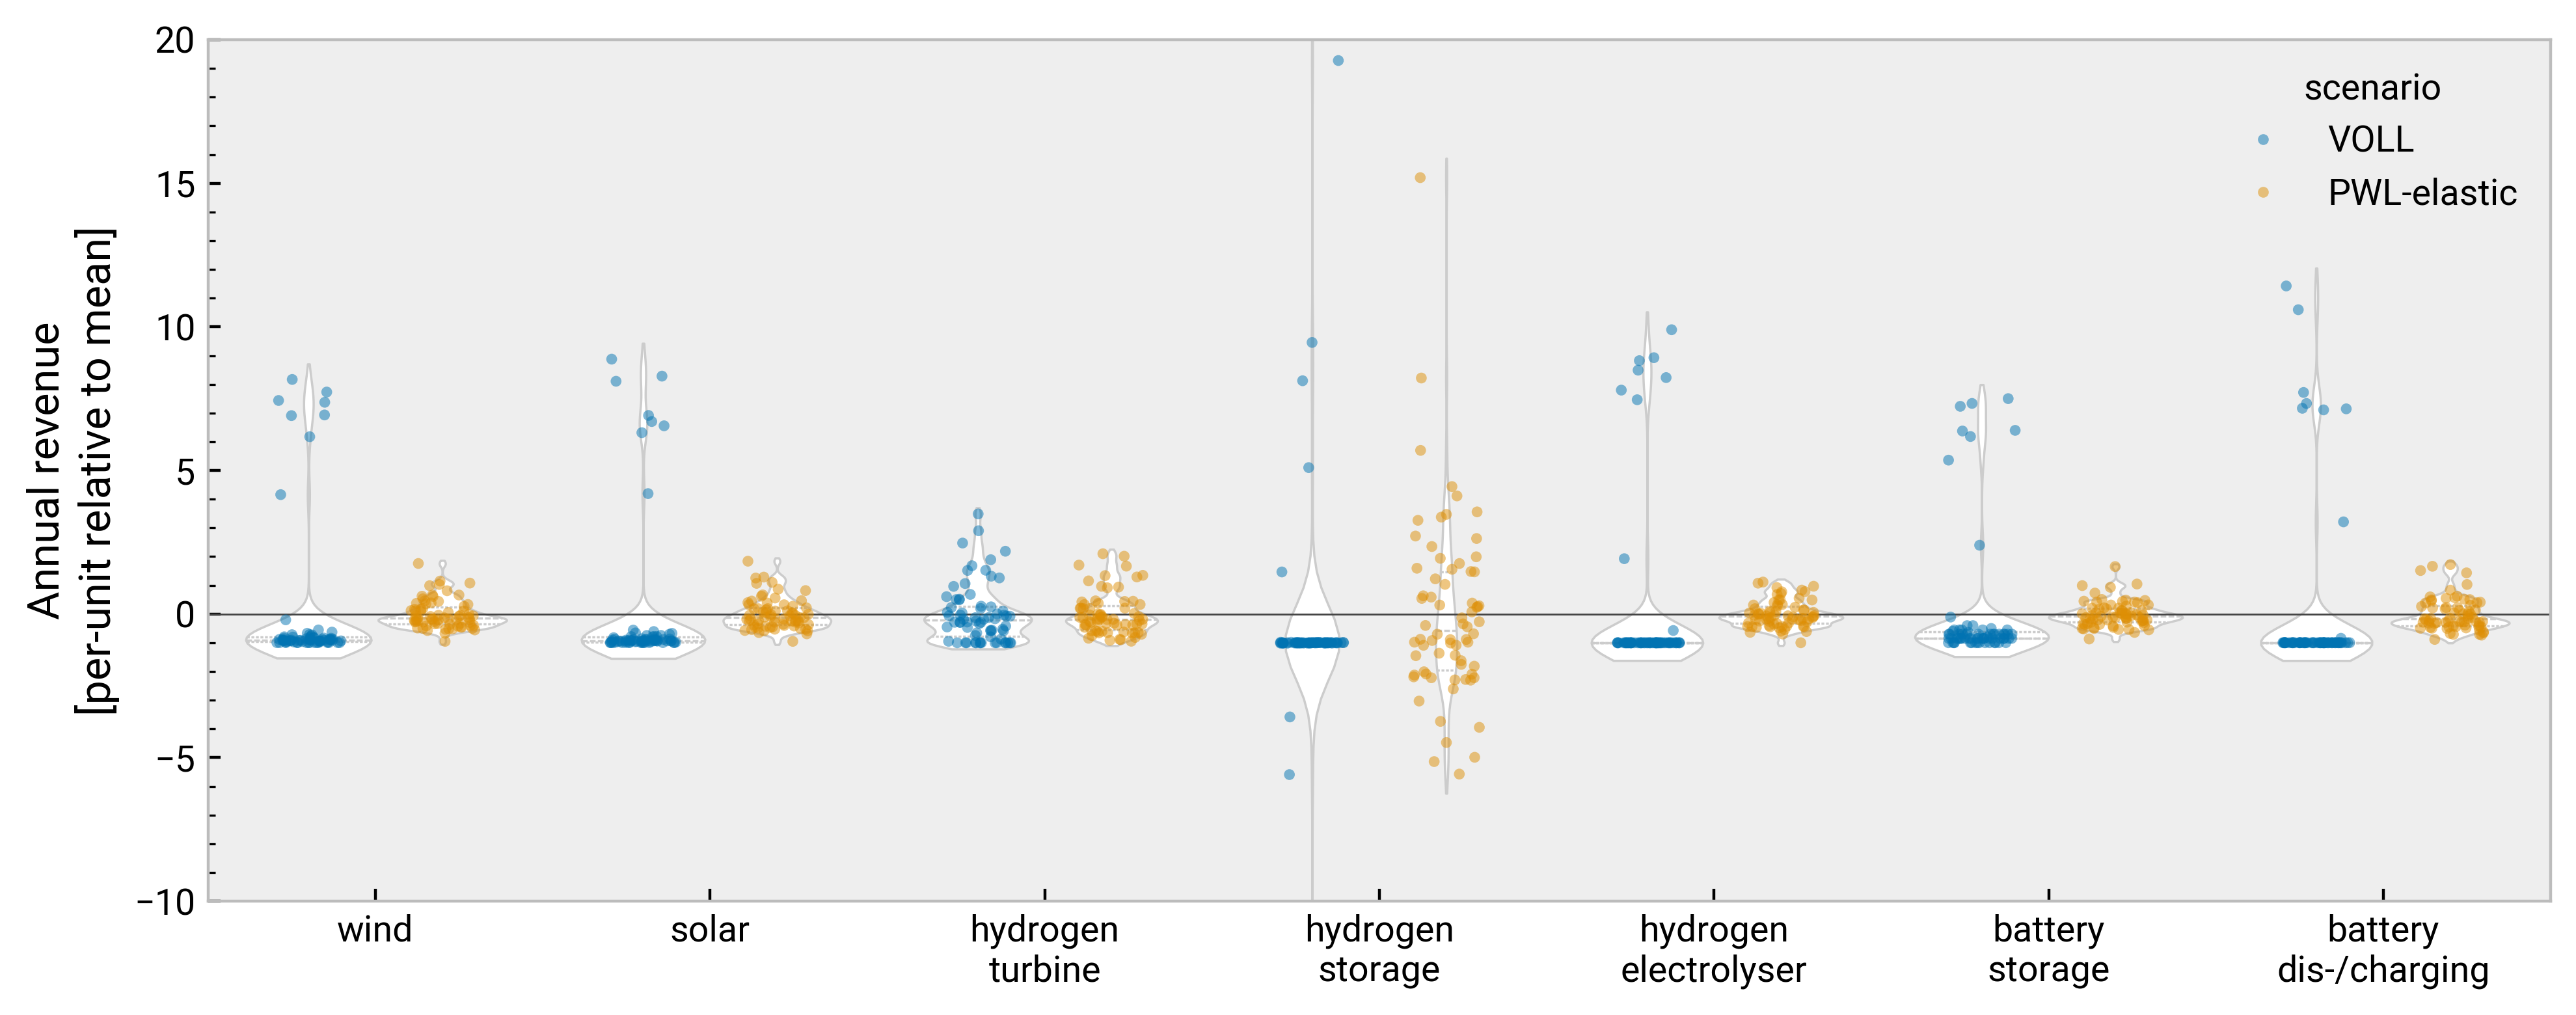

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

sns.stripplot(
    revenues_long,
    ax=ax,
    orient="v",
    x="carrier",
    y="value",
    hue="scenario",
    dodge=True,
    alpha=0.5,
    size=3,
    jitter=0.2,
    hue_order=["VOLL", "PWL-elastic"],
)
sns.violinplot(
    revenues_long,
    ax=ax,
    orient="v",
    x="carrier",
    y="value",
    hue="scenario",
    dodge=True,
    facecolor="#fff",
    edgecolor="#ccc",
    inner="quart",
    # density_norm="area",
    cut=True,
    hue_order=["VOLL", "PWL-elastic"],
    legend=False,
    bw_adjust=0.5,
)

plt.ylabel("Annual revenue\n[per-unit relative to mean]")
plt.ylim(-10, 20)
plt.yticks(range(-10, 20, 1), minor=True)
plt.axhline(0, color="#444", lw=0.5)
plt.xlabel("")

for ext in ["png", "pdf"]:
    plt.savefig(
        f"../../figures/figure-annual-revenue-{COUNTRY}.{ext}", bbox_inches="tight", dpi=300
    )